# Data Science Research Methods
## Assessment 2
### Nestor Prieto Chavana
### 3743 Words



### 1. Introduction

Human Activity Recognition (HAR) is a field with considerable amount of research in its history, however its application in a fitness context is relatively new. The positive impact that regular physical activity has in an individual's health has been documented in many research studies for decades, showing that regular exercise reduces the risk of many diseases such as diabetes and cardiovascular disease. Small and practical electronic devices that measure the user's physical activity are quickly becoming commonplace, as they allow the user to monitor their activity level and seek to achieve the recommended levels of exercise to improve or maintain their health.

In this report, the PAMAP2 Physical Activity Monitoring dataset will be used from this perspective, to extract actionable insights that will allow the development of HAR software and/or hardware for fitness tracking. The PAMAP2 dataset was developed with the objective of providing a standard dataset for predictive model benchmarking that better aligns with the goals of physical aerobic activity monitoring. It contains sensor data for a range of common fitness and daily physical activities performed by a number human subjects. 

In the context of physical activity, the following objectives have been defined for this report:

- **Objective 1:** Identify attributes in the data that will allow the recognition of activity intensity, as defined by their MET equivalent, provided in [1]. The activities included in the dataset can be classified as Light, Moderate and Vigorous activities by their energy consumption. Being able to identify the intensity of activities is useful as it allows users to know if they are getting the recommended levels of physical activity.


- **Objective 2:** Compare the performance of different sensing devices present in the dataset, when applied to the identification of physical activities. In particular, the performance of accelerometer and gyroscope data will be compared to find which one contributes the most to activity recognition. This is useful as knowing the optimal sensor configuration will allow the design of more practical, lightweight and better performing tracking devices. 


- **Objective 3** Compare the performance of the different sensor locations provided in the dataset, namely hand, ankle and chest sensors. Again this knowledge is useful in that it allows the design of better activity tracking devices.

These objectives will be tested by attempting the recognition of a specific set of common fitness and daily activities, focusing on the 12 activities defined in the protocol for the gathering of the PAMAP2 dataset[2].

In [1]:
#Required cell: This cell needs to be executed to import the necessary libraries
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import numpy as np
from scipy import stats
from scipy import integrate
from IPython.display import HTML, display
from scipy.stats import norm
from scipy.stats import t as the
from sklearn import svm
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn import tree
%matplotlib inline
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 70)

### 2. Data Loading and Cleanup

In this section, the activity monitoring data for the different subjects are loaded into a dataframe for cleanup and preprocessing.

**N.B.**  As the loading and preprocessing steps may take a long time to run, the end results have been saved as csv files and provided along with this report, already split into dev and test sets. Code to load the preprocessed data from these files has been included in the Exploratory Data Analysis section. While the code in the next few cells can be executed to validate it's correctness, it's possible to continue reviewing this report without doing it, using these files in case it's taking too long. Only the first two code cells need to be executed, as they contain data structures that will be used throughout this report.

In [2]:
#Required cell: This cell needs to be executed as it contains necessary data structures
#Activity ID map
activity_id = {0: 'transient', 1:'lying', 2:'sitting', 3:'standing',
              4:'walking', 5:'running', 6:'cycling', 7:'Nordic walking',
              9:'watching TV', 10:'computer work', 11:'car driving',
              12:'ascending stairs', 13:'descending stairs', 16:'vacuum cleaning',
              17:'ironing', 18:'folding laundry', 19:'house cleaning',
              20:'playing soccer', 24:'rope jumping'}

#Protocol Activities: lie, sit, stand, walk, run, cycle, Nordic walk, iron, vacuum cleaning, 
#rope jump, ascend and descend stairs
protocol_acts = [1,2,3,4,5,6,7,17,16,24,12,13]

#Optional Activities: watch TV, computer work, drive car, fold laundry, house cleaning, play soccer
optional_acts = [9,10,11,18,19,20]

#MET Classification of activities

#lying, sitting, standing and ironing
light_acts = [1,2,3,17]
#vacuum cleaning, descending stairs, walking, Nordic walking and cycling
mod_acts = [16,13,4,7,6]
#ascending stairs, running and rope jumping
vig_acts = [12,5,24]

#Function used to classify activities
def map_met(act_id):
    if act_id in light_acts:
        return 'light'
    if act_id in mod_acts:
        return 'moderate'
    if act_id in vig_acts:
        return 'vigorous'
    
#Making list for updating column names in dataframe
col_names=['timestamp', 'activity_id', 'heart_rate']

IMU_locations = ['hand', 'chest', 'ankle']
IMU_data = ['tmp', 'acc_16_01', 'acc_16_02', 'acc_16_03',
            'acc_06_01', 'acc_06_02', 'acc_06_03',
            'gyr_01', 'gyr_02', 'gyr_03',
            'mag_01', 'mag_02', 'mag_03',
            'ori_01', 'ori_02', 'ori_03', 'ori_04']

col_names = col_names + [item for sublist in [[dat+'_'+loc for dat in IMU_data] for loc in IMU_locations] for item in sublist]

In the following cell, the subject files are read in sequence and appended to a single dataframe. Columns are added indicating the subject ID for each data row, and their MET classification: light, moderate or vigorous activity.

In [3]:
files = [
    'PAMAP2_Dataset/Protocol/subject101.dat',
    'PAMAP2_Dataset/Protocol/subject102.dat',
    'PAMAP2_Dataset/Protocol/subject103.dat',
    'PAMAP2_Dataset/Protocol/subject104.dat',
    'PAMAP2_Dataset/Protocol/subject105.dat',
    'PAMAP2_Dataset/Protocol/subject106.dat',
    'PAMAP2_Dataset/Protocol/subject107.dat',
    'PAMAP2_Dataset/Protocol/subject108.dat',
    'PAMAP2_Dataset/Protocol/subject109.dat'
]

pamap2 = pd.DataFrame()

for file in files:
    sub_data = pd.read_table(file, header=None, sep='\s+')
    sub_data.columns = col_names
    sub_data['sub_id'] = int(file[-5])
    sub_data['act_level'] = sub_data['activity_id'].apply(map_met)
    pamap2 = pamap2.append(sub_data, ignore_index=True)

As a fist cleanup step, the activity ID 0, which according to [2] corresponds to a transient period between activities is removed from the dataframe.

The next step is keeping only the activities that correspond to each subject as documented in [3]. This is to avoid any unexpected or invalid activity data from affecting results.

The data is then linearly interpolated to account for missing data in some of the rows, such as the HR column.

In [4]:
drop_index = []

#Getting indexes of activity 0
drop_index += list(pamap2.index[pamap2['activity_id']==0])

#Keep only activities as documented on file "PerformedActivitiesSummary.pdf"
drop_index += list(pamap2.index[(pamap2['sub_id']==1) & (pamap2['activity_id'].isin([10,20]))])
drop_index += list(pamap2.index[(pamap2['sub_id']==2) & (pamap2['activity_id'].isin([9,10,11,18,19,20]))])
drop_index += list(pamap2.index[(pamap2['sub_id']==3) & (pamap2['activity_id'].isin([5,6,7,9,10,11,18,19,20,24]))])
drop_index += list(pamap2.index[(pamap2['sub_id']==4) & (pamap2['activity_id'].isin([5,9,10,11,18,19,20,24]))])
drop_index += list(pamap2.index[(pamap2['sub_id']==5) & (pamap2['activity_id'].isin([9,11,18,20]))])
drop_index += list(pamap2.index[(pamap2['sub_id']==6) & (pamap2['activity_id'].isin([9,11,20]))])
drop_index += list(pamap2.index[(pamap2['sub_id']==7) & (pamap2['activity_id'].isin([9,10,11,18,19,20,24]))])
drop_index += list(pamap2.index[(pamap2['sub_id']==8) & (pamap2['activity_id'].isin([9,11]))])
drop_index += list(pamap2.index[(pamap2['sub_id']==9) & (pamap2['activity_id'].isin([1,2,3,4,5,6,7,9,11,12,13,16,17]))])

pamap2 = pamap2.drop(drop_index)
    
#Interpolate data
pamap2 = pamap2.interpolate()

Finally, to account for possible transient data that was incorrectly labelled, the first and last 10 seconds of each activity instance for each user is discarded as well. This is common practice to avoid mislabelling as seen in [2,5,6].

In [5]:
#Remove transients, 10 seconds from the start and end of each activity
freq = 100
pamap2['act_block'] = ((pamap2['activity_id'].shift(1) != pamap2['activity_id']) | (pamap2['sub_id'].shift(1) != pamap2['sub_id'])).astype(int).cumsum()
drop_index = []
numblocks = pamap2['act_block'].max()
for block in range(1, numblocks+1):
    drop_index += list(pamap2[pamap2['act_block']==block].head(10 * freq).index)
    drop_index += list(pamap2[pamap2['act_block']==block].tail(10 * freq).index)
    
pamap2 = pamap2.drop(drop_index)

In [6]:
pamap2.head()

,timestamp,activity_id,heart_rate,tmp_hand,acc_16_01_hand,acc_16_02_hand,acc_16_03_hand,acc_06_01_hand,acc_06_02_hand,acc_06_03_hand,gyr_01_hand,gyr_02_hand,gyr_03_hand,mag_01_hand,mag_02_hand,mag_03_hand,ori_01_hand,ori_02_hand,ori_03_hand,ori_04_hand,tmp_chest,acc_16_01_chest,acc_16_02_chest,acc_16_03_chest,acc_06_01_chest,acc_06_02_chest,acc_06_03_chest,gyr_01_chest,gyr_02_chest,gyr_03_chest,mag_01_chest,mag_02_chest,mag_03_chest,ori_01_chest,ori_02_chest,ori_03_chest,ori_04_chest,tmp_ankle,acc_16_01_ankle,acc_16_02_ankle,acc_16_03_ankle,acc_06_01_ankle,acc_06_02_ankle,acc_06_03_ankle,gyr_01_ankle,gyr_02_ankle,gyr_03_ankle,mag_01_ankle,mag_02_ankle,mag_03_ankle,ori_01_ankle,ori_02_ankle,ori_03_ankle,ori_04_ankle,sub_id,act_level,act_block
3928,47.66,1,103.0,30.5,-7.76319,-6.59656,0.831271,-7.59876,-6.81413,0.952719,-0.023345,-0.094827,0.200758,11.67170,53.3611,-20.7827,1.0,0.0,0.0,0.0,32.3125,-1.42829,4.59099,-9.91106,-1.66712,4.60909,-9.66838,-1.69665,0.073002,0.284169,44.5122,-11.2486,51.2443,1.0,0.0,0.0,0.0,30.875,9.35603,1.448820,-3.44087,9.48208,1.661260,-3.42233,0.100157,-0.328539,0.148857,-74.7494,-45.4312,-41.3917,1.0,0.0,0.0,0.0,1,light,1
3929,47.67,1,103.0,30.5,-7.96283,-6.78714,0.559511,-7.81101,-6.84291,0.832193,0.119344,-0.173491,0.228492,10.79910,53.7261,-19.8429,1.0,0.0,0.0,0.0,32.3125,-1.30241,4.63088,-9.52170,-1.62106,4.68434,-9.59287,-1.77871,0.069577,0.317669,44.0021,-12.7925,50.8668,1.0,0.0,0.0,0.0,30.875,9.45772,1.108960,-3.74644,9.40729,1.449600,-3.33044,0.022160,-0.316792,0.150338,-76.0839,-46.1565,-41.3886,1.0,0.0,0.0,0.0,1,light,1
3930,47.68,1,103.0,30.5,-7.56159,-6.94546,0.181182,-7.78390,-6.97924,0.605953,0.293628,-0.223687,0.237504,10.24440,53.4288,-19.6083,1.0,0.0,0.0,0.0,32.3125,-1.10925,4.74376,-9.44113,-1.48431,4.77441,-9.45742,-1.75758,0.041567,0.325210,44.5969,-13.3610,49.7718,1.0,0.0,0.0,0.0,30.875,8.73577,0.508215,-4.02024,9.13637,0.920061,-3.41811,0.000155,-0.259867,0.156328,-75.4083,-45.9693,-40.6494,1.0,0.0,0.0,0.0,1,light,1
3931,47.69,1,103.0,30.5,-7.27130,-7.14018,-0.121712,-7.59227,-7.11690,0.228539,0.516965,-0.241007,0.224821,9.80950,52.9010,-18.9146,1.0,0.0,0.0,0.0,32.3125,-1.17896,5.04652,-9.24977,-1.43726,4.86454,-9.23076,-1.84174,-0.005494,0.366242,44.5062,-13.9122,49.2794,1.0,0.0,0.0,0.0,30.875,9.52078,0.959822,-4.13076,8.82006,0.798751,-3.61280,-0.003502,-0.218614,0.199243,-76.1764,-46.5085,-39.5349,1.0,0.0,0.0,0.0,1,light,1
3932,47.70,1,103.0,30.5,-7.19573,-6.95140,-0.159704,-7.24956,-7.30087,-0.058323,0.646473,-0.272410,0.216307,9.98846,52.2646,-21.0066,1.0,0.0,0.0,0.0,32.3125,-1.28709,5.23644,-9.05874,-1.48014,5.07573,-9.07876,-1.85351,-0.055315,0.391737,44.3054,-14.8072,50.1332,1.0,0.0,0.0,0.0,30.875,9.25510,0.886508,-4.24880,9.34472,1.101010,-3.90413,-0.015711,-0.279977,0.195484,-76.4170,-45.6111,-40.0185,1.0,0.0,0.0,0.0,1,light,1


### 3. Segmentation

The resulting dataset after cleanup is quite unwieldy, with almost 3 million rows, and it's difficult to perform a feasible analysis directly. It's therefore necessary to segment the dataset, which for this report will be done using a sliding window technique. The data is segmented using a sliding window of 5.12 seconds, which has been found a suitable window of time to capture movement cycles, using a 1 second displacement between consecutive windows. Features are then extracted from the raw data, which will be used for analysis and creation of a predictive model.

For the accelerometer and gyroscope data, the following features are extracted for each axis of each device, and correlation is calculated for pair-wise combinations of their axes.

- Mean
- Standard Deviation
- Correlation

For the HR data, the following features are extracted. HR is normalised using the subjects resting HR, found in the file SubjectInformation.pdf included with the dataset.

- Mean
- Normalised Mean
- Standard Deviation
- Normalised Standard Deviation

For the temperature data, the following features are extracted.
- Mean
- Standard Deviation

Similar segmentation and feature selection processes have been found successful in previous works such as [2,5,7].

In [7]:
freq = 100
windowsize = int(5.12 * freq)
displacement = 1*freq

#columns used for analysis
columns_used = ['sub_id', 'activity_id', 'act_level', 'heart_rate',
                'tmp_hand','acc_16_01_hand','acc_16_02_hand','acc_16_03_hand',
                'gyr_01_hand','gyr_02_hand','gyr_03_hand',
                'tmp_chest','acc_16_01_chest','acc_16_02_chest','acc_16_03_chest',
                'gyr_01_chest','gyr_02_chest','gyr_03_chest',
                'tmp_ankle','acc_16_01_ankle','acc_16_02_ankle','acc_16_03_ankle',
                'gyr_01_ankle','gyr_02_ankle','gyr_03_ankle']

#resting HR for participating subjects, used for normalisation
sub_rest_hr = {1:75, 2:74, 3:68, 4:58, 5:70, 6:60, 7:60, 8:66, 9:54}

windows = []

#Sliding window of 5.12 seconds, equaling 512 instances of data, with 1 second of overlap
for block in range(1, numblocks+1):
    ar = np.array(pamap2[pamap2['act_block']==block][columns_used])
    start_index = 0
    while True:
        if len(ar[start_index:start_index+windowsize,:])<512:
            break
        windows.append(ar[start_index:start_index+windowsize,:])
        start_index += displacement

#Next the features for each window are calculated
window_features = []
for window in windows:
    features = []
    #Adding Subject ID, Activity ID and Activity Level for ground truth
    features.append(window[0][0])
    features.append(window[0][1])
    features.append(window[0][2])
    #Computing mean, normalised mean and std for HR data
    features.append(np.mean(window[:,3]))
    features.append(np.mean(window[:,3]/sub_rest_hr[window[0][0]]))
    features.append(np.std(window[:,3]))
    features.append(np.std(window[:,3]/sub_rest_hr[window[0][0]]))
    #Computing mean and std for the rest of the columns
    for col in range(4,25):
        features.append(np.mean(window[:,col]))
        features.append(np.std(window[:,col]))
    #Computing correlation between axes for hand Accelerometer    
    features.append(stats.spearmanr(window[:,5],window[:,6])[0])
    features.append(stats.spearmanr(window[:,6],window[:,7])[0])
    features.append(stats.spearmanr(window[:,5],window[:,7])[0])
    #Computing correlation between axes for chest Accelerometer  
    features.append(stats.spearmanr(window[:,12],window[:,13])[0])
    features.append(stats.spearmanr(window[:,13],window[:,14])[0])
    features.append(stats.spearmanr(window[:,12],window[:,14])[0])
    #Computing correlation between axes for ankle Accelerometer
    features.append(stats.spearmanr(window[:,19],window[:,20])[0])
    features.append(stats.spearmanr(window[:,20],window[:,21])[0])
    features.append(stats.spearmanr(window[:,19],window[:,21])[0])
    #Computing correlation between axes for hand Gyroscope    
    features.append(stats.spearmanr(window[:,8],window[:,9])[0])
    features.append(stats.spearmanr(window[:,9],window[:,10])[0])
    features.append(stats.spearmanr(window[:,8],window[:,10])[0])
    #Computing correlation between axes for chest Gyroscope  
    features.append(stats.spearmanr(window[:,15],window[:,16])[0])
    features.append(stats.spearmanr(window[:,16],window[:,17])[0])
    features.append(stats.spearmanr(window[:,15],window[:,17])[0])
    #Computing correlation between axes for ankle Gyroscope
    features.append(stats.spearmanr(window[:,22],window[:,23])[0])
    features.append(stats.spearmanr(window[:,23],window[:,24])[0])
    features.append(stats.spearmanr(window[:,22],window[:,24])[0])
    window_features.append(features)

#new dataframe with features for each window
features = pd.DataFrame(window_features)

In [8]:
features.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66
0,1,1,light,103.951172,1.386016,0.805429,0.010739,30.523682,0.030320,-1.879247,3.534154,4.788385,2.567330,6.990495,1.965119,0.107901,0.466133,-0.251155,0.366370,0.211265,0.456911,32.323120,0.023473,1.521597,1.132801,5.122803,3.014503,5.573594,5.041338,-0.487434,0.561027,-0.086311,0.294916,0.101015,0.336984,30.900513,0.030719,2.413188,3.686631,-7.901836,3.011201,-4.319748,1.431167,-0.027212,0.486969,0.053937,0.474670,0.407518,0.913272,0.464139,0.055267,0.510214,0.511312,-0.799051,-0.302004,0.264226,-0.113223,0.314868,-0.531362,-0.581758,0.530794,0.230082,-0.481656,-0.604763,0.325803,-0.294619,-0.170427
1,1,1,light,104.509766,1.393464,0.952667,0.012702,30.535889,0.030904,-0.185149,1.377860,5.695728,0.972648,7.785865,0.751240,-0.009273,0.381659,-0.113646,0.258900,0.043581,0.215902,32.335327,0.030093,1.475562,1.023636,3.805870,2.555193,8.036729,2.391985,-0.255809,0.411611,0.009638,0.174810,-0.005376,0.236450,30.912720,0.030573,0.609043,1.205205,-8.821382,1.874376,-4.609152,1.303216,-0.045085,0.330023,0.014152,0.202536,0.046104,0.258117,0.028908,-0.684904,0.096735,0.619179,-0.638843,-0.491480,-0.427727,-0.389651,0.486994,-0.282832,-0.248817,0.230088,-0.118856,-0.139842,-0.481102,0.194234,-0.368513,-0.292237
2,1,1,light,105.253906,1.403385,1.094676,0.014596,30.548096,0.026321,0.319354,0.447698,5.626324,0.819042,7.950312,0.582057,-0.037028,0.274945,-0.016048,0.083449,-0.029576,0.083680,32.347534,0.031020,1.085746,0.737306,2.650548,1.082055,9.169791,0.582381,-0.111460,0.330841,0.024648,0.143875,-0.048026,0.205479,30.924927,0.025055,0.226354,1.141336,-8.691025,1.764263,-4.796809,1.227335,-0.031455,0.262951,-0.013533,0.102034,0.037852,0.237697,0.129201,-0.685796,-0.184500,0.190822,-0.328401,-0.034166,-0.562640,-0.522007,0.588619,-0.162304,0.219523,0.154424,-0.130829,-0.111774,-0.385171,0.214233,-0.311803,-0.179082
3,1,1,light,105.839844,1.411198,1.069291,0.014257,30.555542,0.019659,0.322273,0.326337,5.483047,0.568834,8.098098,0.372352,0.029006,0.152585,0.000316,0.055307,-0.006781,0.042133,32.359741,0.026849,0.875531,0.400173,2.274730,0.498286,9.317323,0.253320,-0.035471,0.129909,-0.000624,0.093716,0.017624,0.097199,30.937134,0.004770,-0.141292,0.981405,-8.506603,1.748027,-5.133278,1.202987,-0.051114,0.199645,-0.012446,0.088246,0.053858,0.207330,0.134870,-0.670430,-0.109069,-0.280928,-0.168570,0.215786,-0.328764,-0.544402,0.499454,-0.300674,0.085189,-0.138638,0.257661,-0.379470,-0.646042,0.187620,-0.438468,-0.192798
4,1,1,light,106.339844,1.417865,0.853795,0.011384,30.558350,0.015562,0.316246,0.102791,5.702229,0.209482,7.966321,0.143267,0.009624,0.092451,0.001428,0.025731,-0.010280,0.025021,32.371948,0.013469,0.958177,0.216285,2.088273,0.369734,9.364349,0.213946,-0.006847,0.072573,-0.006268,0.058533,-0.006317,0.067592,30.937500,0.000000,-0.584390,0.345254,-8.254930,1.697411,-5.647530,0.819204,-0.053999,0.155904,-0.009388,0.079133,0.039167,0.198324,-0.089136,-0.450723,0.222441,-0.109808,-0.121974,0.081106,0.164706,-0.425811,0.105384,-0.167682,0.148621,-0.260610,0.276035,-0.401572,-0.531046,0.008690,-0.389506,-0.293527


Column names are added to the features dataframe. Finally, the dataframe is divided into development and testing datasets with a 70-30 split.

In [10]:
#Generating column list for features dataset
feature_names = ['sub_id','activity_id','act_level','hr_mean','hr_mean_normal','hr_std', 'hr_std_normal']
locs = ['hand','chest','ankle']
cols = ['tmp','acc_x','acc_y','acc_z', 'gyr_x','gyr_y','gyr_z']
feats = ['mean','std']

for loc in locs:
    for col in cols:
        for feat in feats:
            feature_names.append(loc + '_' + col + '_' + feat)
for loc in locs:
    feature_names += [loc + '_acc_xy_cor', loc + '_acc_yz_cor', loc + '_acc_xz_cor']

for loc in locs:
    feature_names += [loc + '_gyr_xy_cor', loc + '_gyr_yz_cor', loc + '_gyr_xz_cor']

features.columns = feature_names

#Using a seed to facilitate replication of results
dev_data_df = features.sample(frac=0.7, random_state=1)
test_data_df = features.drop(dev_data_df.index)

In [11]:
dev_data_df.head()

,sub_id,activity_id,act_level,hr_mean,hr_mean_normal,hr_std,hr_std_normal,hand_tmp_mean,hand_tmp_std,hand_acc_x_mean,hand_acc_x_std,hand_acc_y_mean,hand_acc_y_std,hand_acc_z_mean,hand_acc_z_std,hand_gyr_x_mean,hand_gyr_x_std,hand_gyr_y_mean,hand_gyr_y_std,hand_gyr_z_mean,hand_gyr_z_std,chest_tmp_mean,chest_tmp_std,chest_acc_x_mean,chest_acc_x_std,chest_acc_y_mean,chest_acc_y_std,chest_acc_z_mean,chest_acc_z_std,chest_gyr_x_mean,chest_gyr_x_std,chest_gyr_y_mean,chest_gyr_y_std,chest_gyr_z_mean,chest_gyr_z_std,ankle_tmp_mean,ankle_tmp_std,ankle_acc_x_mean,ankle_acc_x_std,ankle_acc_y_mean,ankle_acc_y_std,ankle_acc_z_mean,ankle_acc_z_std,ankle_gyr_x_mean,ankle_gyr_x_std,ankle_gyr_y_mean,ankle_gyr_y_std,ankle_gyr_z_mean,ankle_gyr_z_std,hand_acc_xy_cor,hand_acc_yz_cor,hand_acc_xz_cor,chest_acc_xy_cor,chest_acc_yz_cor,chest_acc_xz_cor,ankle_acc_xy_cor,ankle_acc_yz_cor,ankle_acc_xz_cor,hand_gyr_xy_cor,hand_gyr_yz_cor,hand_gyr_xz_cor,chest_gyr_xy_cor,chest_gyr_yz_cor,chest_gyr_xz_cor,ankle_gyr_xy_cor,ankle_gyr_yz_cor,ankle_gyr_xz_cor
3006,2,17,light,87.000000,1.175676,0.000000,7.105427e-15,34.3750,0.0,-1.165524,2.383779,3.381285,2.582771,8.492507,1.224852,0.093030,0.719383,-0.080050,0.494687,-0.170838,0.980066,37.750000,0.000000,-0.574081,0.956643,8.924554,0.575753,-4.355411,0.852119,0.052130,0.172671,-0.127863,0.550284,0.069405,0.261474,35.1250,0.0,9.613680,0.141006,-2.034883,0.449276,-0.675058,0.722426,0.003878,0.260395,-0.039163,0.099164,0.003677,0.141914,0.614900,-0.749890,-0.252158,-0.096426,0.451917,-0.137126,0.291370,-0.242012,0.233251,-0.472662,0.335516,-0.377507,-0.290138,-0.779952,0.071855,-0.305959,-0.003001,-0.638866
3497,2,4,moderate,124.605469,1.683858,0.927920,1.253946e-02,31.8750,0.0,-12.040995,3.734766,3.069947,2.591651,1.161251,1.837110,0.055998,2.159256,-0.031960,0.962742,0.089741,3.720493,36.500000,0.000000,0.526051,2.046854,8.318571,2.496176,-5.332919,2.201650,0.022321,0.314681,-0.036313,0.806525,-0.011805,0.666682,34.5625,0.0,11.712190,5.814112,0.068395,7.408032,-1.578947,3.224426,-0.089607,1.419706,-0.109581,0.823423,-0.033989,3.099118,-0.238044,-0.186898,0.162161,-0.007312,-0.513200,0.059846,0.128946,-0.270560,-0.119772,-0.287380,-0.230390,-0.491314,0.011124,-0.799319,-0.135736,-0.653133,-0.654575,0.391363
14495,7,5,vigorous,113.493430,1.891557,2.315888,3.859813e-02,32.5000,0.0,-3.723040,10.188184,11.705779,17.220389,-1.367870,4.527840,0.186308,2.657634,0.321703,2.115963,-0.036559,2.807273,36.756836,0.019507,0.740500,3.648823,9.913660,11.646691,-0.689218,3.454264,0.064076,0.904309,0.242770,1.406050,-0.009270,0.686093,32.0000,0.0,14.272593,19.002270,4.774907,16.373748,-4.488213,13.319767,0.268098,2.850637,-0.214467,1.461636,0.173994,4.399006,-0.226895,-0.685601,0.441670,-0.033515,0.167499,-0.246121,-0.083889,0.418781,0.025673,-0.265566,0.824691,-0.121345,-0.004923,-0.317761,-0.202148,-0.660278,-0.528138,0.402147
13278,7,17,light,82.513672,1.375228,0.492657,8.210948e-03,33.8125,0.0,-3.618932,1.935690,0.542981,2.907890,8.430229,0.975924,-0.163251,0.502349,0.209826,0.456587,0.271169,0.886100,36.750000,0.000000,0.185189,1.393045,9.358609,0.220221,-3.092576,0.264225,0.003291,0.064052,0.034760,0.096851,-0.095510,0.132262,32.8125,0.0,9.280206,0.111226,-0.821241,0.193480,-3.597638,0.332495,0.007408,0.061254,0.007822,0.044353,0.009165,0.047432,0.435401,0.031484,0.092153,-0.458219,0.108914,-0.342861,-0.274557,-0.555554,0.724061,-0.196728,0.315984,-0.380337,0.284190,-0.109078,-0.071734,-0.177813,0.237828,-0.729771
14969,8,3,light,73.000000,1.106061,0.000000,7.327472e-15,34.4375,0.0,-9.275877,0.082824,1.006239,0.153816,2.709588,0.155286,-0.008753,0.049173,0.002632,0.025952,-0.001796,0.027531,37.562500,0.000000,-1.116647,0.108927,9.665873,0.098028,0.706836,0.171972,0.010735,0.044164,0.004822,0.046422,-0.016413,0.019973,34.1250,0.0,6.686333,0.077043,-7.266617,0.080816,-1.471347,0.167118,-0.000961,0.039025,0.000421,0.028817,0.005620,0.017938,0.221818,-0.077456,0.344009,0.069912,0.031856,0.127825,0.468236,-0.292715,-0.001651,-0.

Due to the long execution time of the pre-processing and feature extraction steps, the development and test datasets have been stored in csv files, which have been provided along with this report. This allows execution of the analysis steps without the need to perform preprocessing each time. 

In [12]:
#Uncomment the following lines to save the features dataframes to local files
#dev_data_df.to_csv("dev_data", index=False)
#test_data_df.to_csv("test_data", index=False)

### 4. Exploratory Data Analysis

With the features extracted from the raw data and partitioned into development and testing, exploratory data analysis can now be performed on our development dataset.

First, an overview of the development dataset distribution will be given. The dataset is composed of 11773 windows which are each labelled with their corresponding activity id and intensity level.

In [3]:
#Uncomment the following lines to read features from csv files
#dev_data_df = pd.read_csv("dev_data", header=0)
#test_data_df = pd.read_csv("test_data", header=0)

Dev Dataset by Activity


ascending stairs     1539
walking              1525
standing             1220
lying                1203
Nordic walking       1196
sitting              1162
rope jumping         1099
cycling              1035
running               593
ironing               522
vacuum cleaning       428
descending stairs     251
Name: Activity Counts, dtype: int64

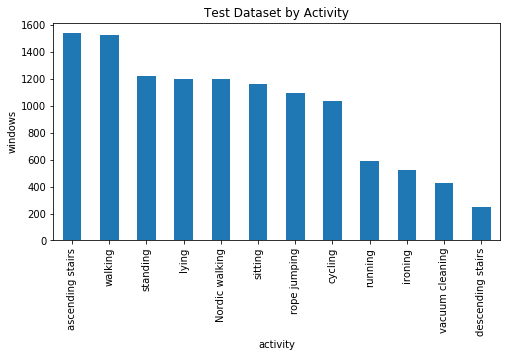

In [4]:
s = dev_data_df.groupby('activity_id').count()['act_level']
s = s.rename("Activity Counts")
s.index = [activity_id[x] for x in protocol_acts]
print(('Dev Dataset by Activity'))
display(s.sort_values(ascending =False))
ax = s.sort_values(ascending =False).plot(kind='bar', figsize=(8,4))
_ = ax.set_ylabel('windows')
_ = ax.set_xlabel('activity')
_ = ax.set_title('Test Dataset by Activity') 

As defined by their MET will be looked for. According to [1,2], the activities in the protocol can be classified as:
- Light Effort         (<3.0 METs): lying, sitting, standing and ironing
- Moderate Effort (3.0 - 6.0 METs): vacuum cleaning, descending stairs, walking, Nordic walking and cycling
- Vigorous Effort      (> 6.0 MET): ascending stairs, running and rope jumping

Dev Dataset by Activity Intensity Level


act_level
light       5124
moderate    5283
vigorous    1366
Name: Activity Level Counts, dtype: int64

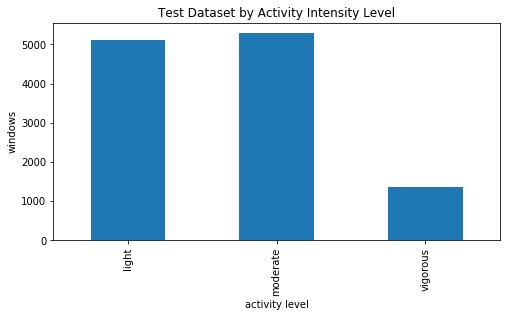

In [6]:
s = dev_data_df.groupby('act_level').count()['activity_id']
s = s.rename("Activity Level Counts")
print(('Dev Dataset by Activity Intensity Level'))
display(s)
ax = s.plot(kind='bar', figsize=(8,4))
_ = ax.set_ylabel('windows')
_ = ax.set_xlabel('activity level')
_ = ax.set_title('Test Dataset by Activity Intensity Level') 

The following functions have been created to facilitate the plotting of dataframes with a specific formatting. They will be used to explore some features during EDA.

In [16]:
def plot_heatmap(df, title, xlabel, ylabel, xticks, yticks, showcbar=True, showannot=False):
    """Function used to plot heatmap using input dataframe"""
    mycmap = LinearSegmentedColormap.from_list('mycmap', ['lightgreen', 'tomato'])
    fig = plt.figure(figsize=(6,6))
    ax = fig.gca()
    _ = sns.heatmap(df, cmap = mycmap, yticklabels=yticks, xticklabels=xticks, square=True,\
                    linewidths=0.01, cbar=showcbar, annot=showannot,fmt='.1f')
    _ = ax.set_ylabel(ylabel)
    _ = ax.set_xlabel(xlabel)
    _ = ax.set_title(title)
    
def plot_series(df, feat, location, act, unit, pylim):
    plottitle = location + ' ' + feat + ' - ' + act
    plotx = location.lower() + '_' + feat.lower()[0:3] + '_x_mean'
    ploty = location.lower() + '_' + feat.lower()[0:3] + '_y_mean'
    plotz = location.lower() + '_' + feat.lower()[0:3] + '_z_mean'
    ax1 = df.plot(x=df.index,y=plotx, color='r', figsize=(12,5), ylim=pylim)
    _ = df.plot(x=df.index,y=ploty, color='g', ax=ax1)
    _ = df.plot(x=df.index,y=plotz, color='b', ax=ax1)
    _ = ax1.set_title(plottitle)
    _ = ax1.set_xlabel('window')
    _ = ax1.set_ylabel(unit)

One promising feature that could be used to classify activities by their intensity level is heart rate. In the following cell, a heat map of average heart rate by activity and subject is plotted, to explore their interaction.

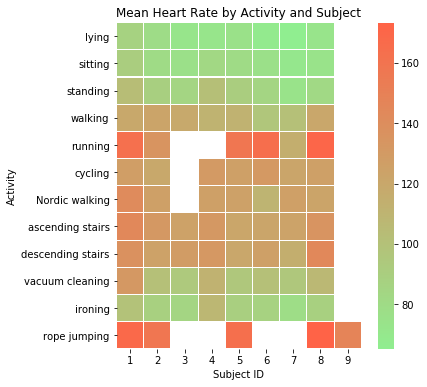

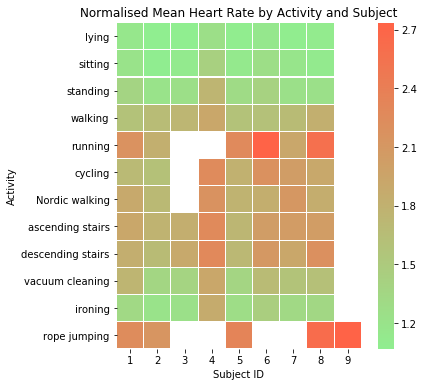

In [17]:
yticks = [y for x, y in activity_id.items() if x in protocol_acts]
xticks = [1,2,3,4,5,6,7,8,9]
ylabel = 'Activity'
xlabel = 'Subject ID'

title = 'Mean Heart Rate by Activity and Subject'
df = dev_data_df.groupby(['activity_id','sub_id'], as_index=False).mean() \
            [['activity_id','sub_id','hr_mean']].pivot(index='activity_id', columns='sub_id', values='hr_mean')
plot_heatmap(df, title, xlabel, ylabel, xticks, yticks)

title = 'Normalised Mean Heart Rate by Activity and Subject'
df = dev_data_df.groupby(['activity_id','sub_id'], as_index=False).mean() \
            [['activity_id','sub_id','hr_mean_normal']].pivot(index='activity_id', columns='sub_id', values='hr_mean_normal')
plot_heatmap(df, title, xlabel, ylabel, xticks, yticks)

The same plot, now grouped by activity level and subject id is shown below. From these plots, it looks like heart rate may indeed be enough to predict activity level on its own, since it's value closely follows the division between categories.

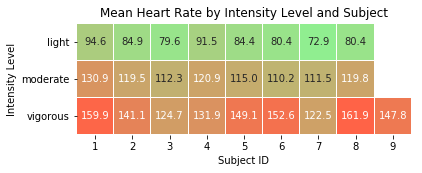

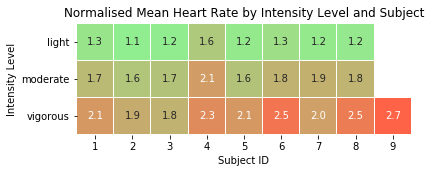

In [18]:
df = dev_data_df.groupby(['act_level','sub_id'], as_index=False).mean() \
            [['act_level','sub_id','hr_mean']].pivot(index='act_level', columns='sub_id', values='hr_mean')
    
yticks = ['light','moderate','vigorous']
xticks = [1,2,3,4,5,6,7,8,9]
ylabel = 'Intensity Level'
xlabel = 'Subject ID'
title = 'Mean Heart Rate by Intensity Level and Subject'
plot_heatmap(df, title, xlabel, ylabel, xticks, yticks, showcbar=False, showannot=True)

df = dev_data_df.groupby(['act_level','sub_id'], as_index=False).mean() \
            [['act_level','sub_id','hr_mean_normal']].pivot(index='act_level', columns='sub_id', values='hr_mean_normal')
title = 'Normalised Mean Heart Rate by Intensity Level and Subject'
plot_heatmap(df, title, xlabel, ylabel, xticks, yticks, showcbar=False, showannot=True)

Another feature that might prove useful in activity classification is temperature. Below, the mean temperature readings for the different sensor locations are plotted by activity and subject. 

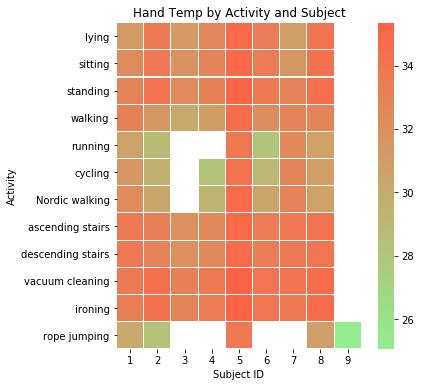

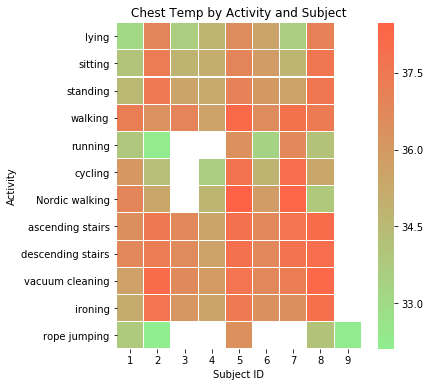

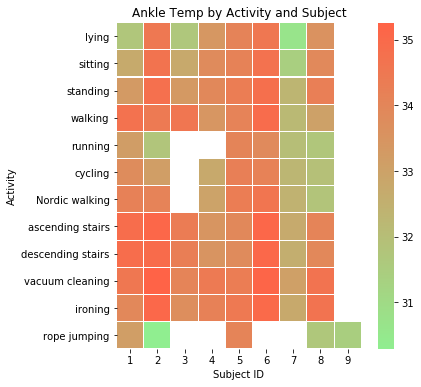

In [19]:
yticks = [y for x, y in activity_id.items() if x in protocol_acts]
xticks = [1,2,3,4,5,6,7,8,9]
ylabel = 'Activity'
xlabel = 'Subject ID'

title = 'Hand Temp by Activity and Subject'
df = dev_data_df.groupby(['activity_id','sub_id'], as_index=False).mean() \
            [['activity_id','sub_id','hand_tmp_mean']].pivot(index='activity_id', columns='sub_id', values='hand_tmp_mean')
plot_heatmap(df, title, xlabel, ylabel, xticks, yticks)

title = 'Chest Temp by Activity and Subject'
df = dev_data_df.groupby(['activity_id','sub_id'], as_index=False).mean() \
            [['activity_id','sub_id','chest_tmp_mean']].pivot(index='activity_id', columns='sub_id', values='chest_tmp_mean')
plot_heatmap(df, title, xlabel, ylabel, xticks, yticks)

title = 'Ankle Temp by Activity and Subject'
df = dev_data_df.groupby(['activity_id','sub_id'], as_index=False).mean() \
            [['activity_id','sub_id','ankle_tmp_mean']].pivot(index='activity_id', columns='sub_id', values='ankle_tmp_mean')
plot_heatmap(df, title, xlabel, ylabel, xticks, yticks)

Looking at the average temperature plots, it looks like it might not be that useful for differentiating between activities. Indeed, it's value seems more dependent on the subject than the activity itself.

The rest of the available features are composed of sensor readings for different types of devices, specifically accelerometer and gyroscopes. One of each sensor was located at hand, chest and ankle locations. The readings from these devices should provide suitable patterns for each activity so that a classifier model is able to identify them using these features.

In the next cell, accelerometer readings for each location are visualized for three different activities of increasing intensity: lying, walking and running. The objective is that the patterns created by each activity should be different enough to make that activity recognizable.

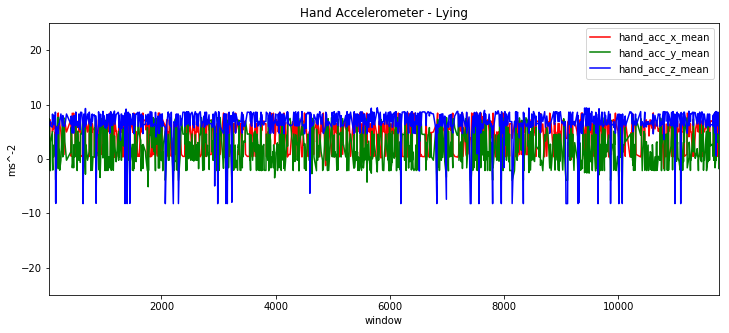

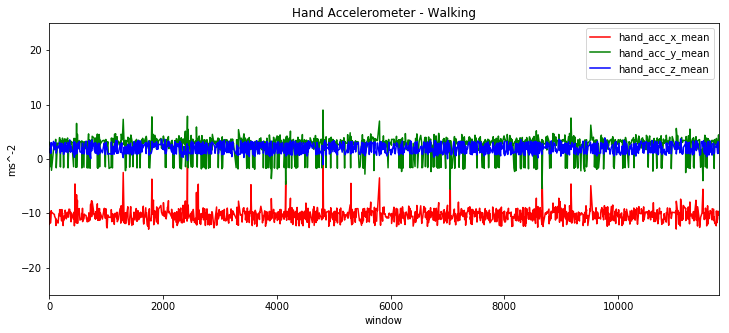

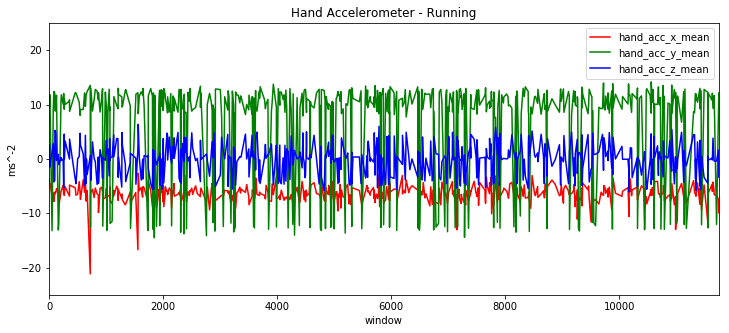

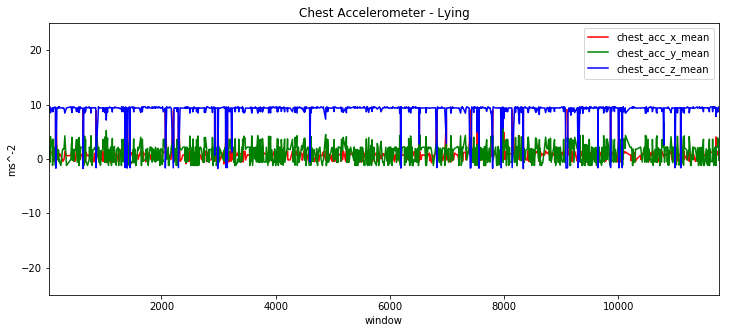

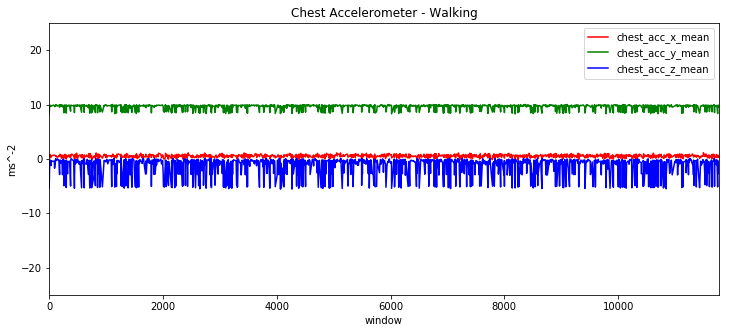

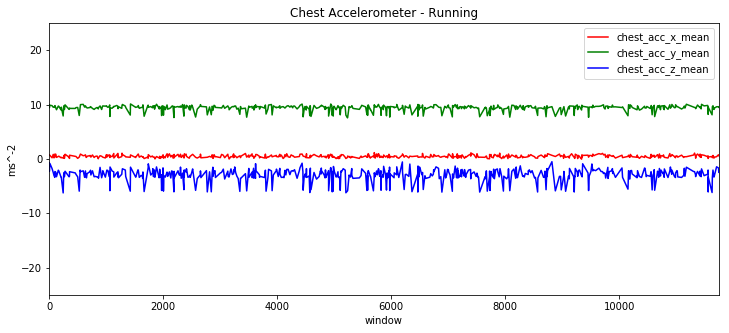

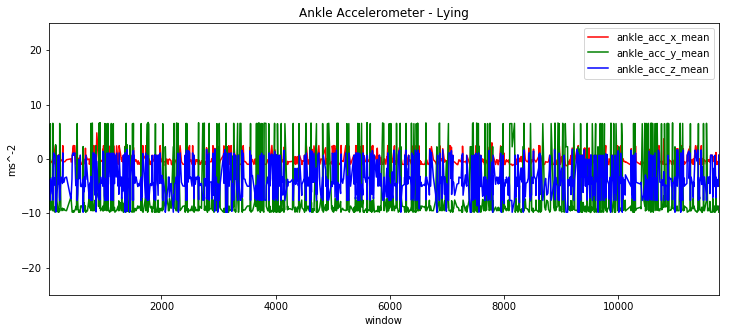

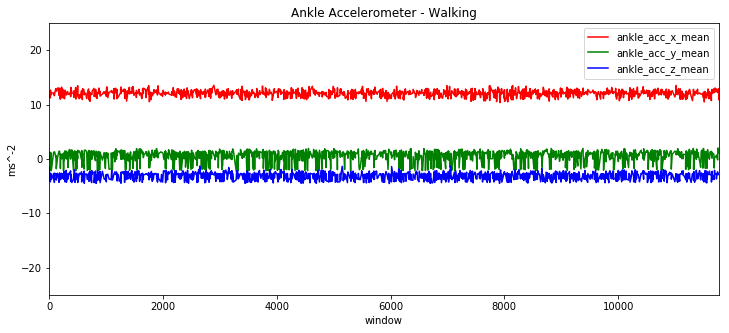

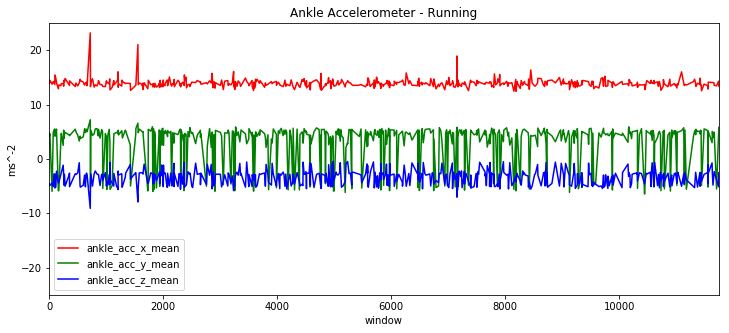

In [20]:
df1=dev_data_df[dev_data_df['activity_id']==1]
df2=dev_data_df[dev_data_df['activity_id']==4]
df3=dev_data_df[dev_data_df['activity_id']==5]

feat = 'Accelerometer'
unit = 'ms^-2'
pylimit = (-25,25)

plot_series(df1, feat, 'Hand', 'Lying', unit, pylimit)
plot_series(df2, feat, 'Hand', 'Walking', unit, pylimit)
plot_series(df3, feat, 'Hand', 'Running', unit, pylimit)

plot_series(df1, feat, 'Chest', 'Lying', unit, pylimit)
plot_series(df2, feat, 'Chest', 'Walking', unit, pylimit)
plot_series(df3, feat, 'Chest', 'Running', unit, pylimit)

plot_series(df1, feat, 'Ankle', 'Lying', unit, pylimit)
plot_series(df2, feat, 'Ankle', 'Walking', unit, pylimit)
plot_series(df3, feat, 'Ankle', 'Running', unit, pylimit)

The signals captured from each accelerometer location appear to be distinguishable enough, though it might be necessary to consider more than one location at a time in order to classify them correctly.

Next, the exercise is repeated with the readings from the gyroscope sensors, for the same locations and activities.

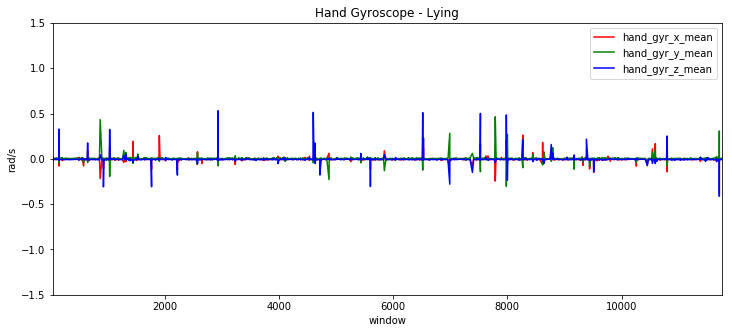

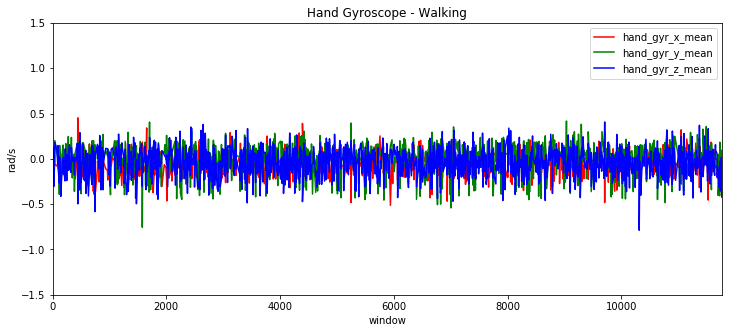

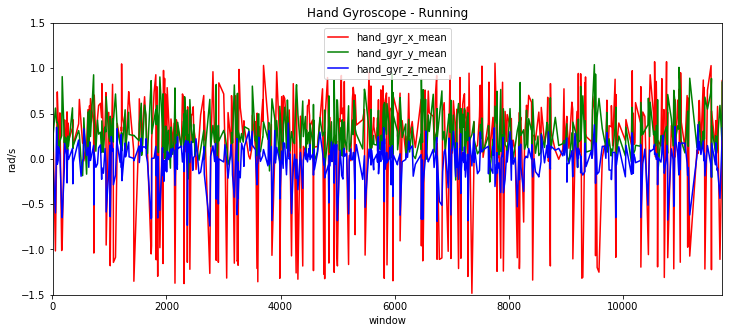

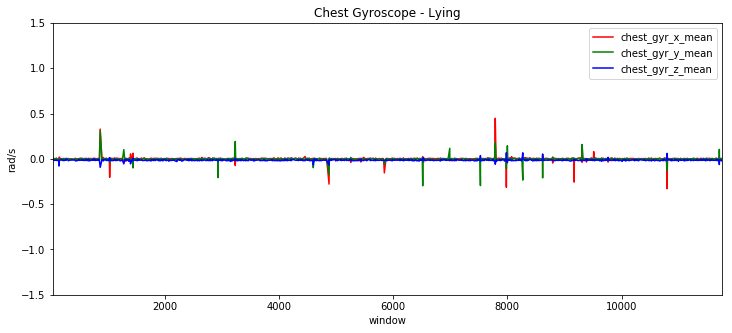

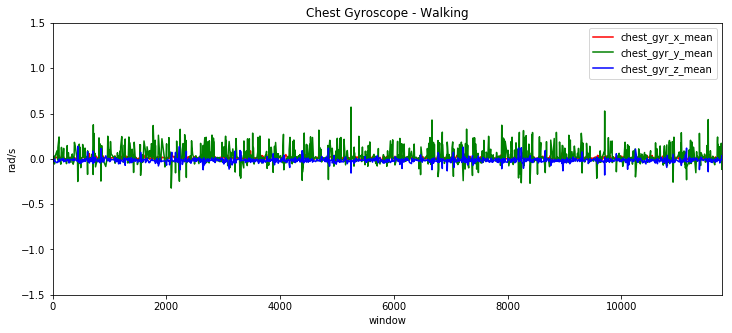

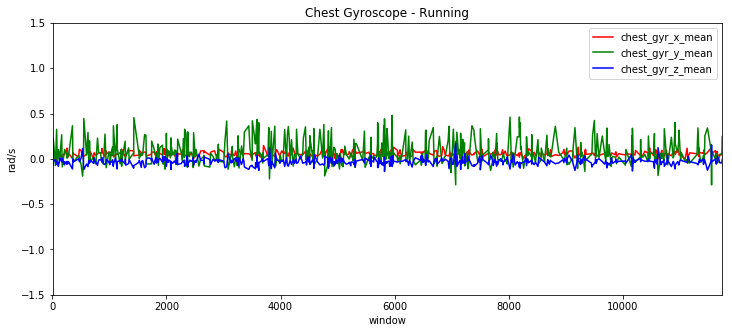

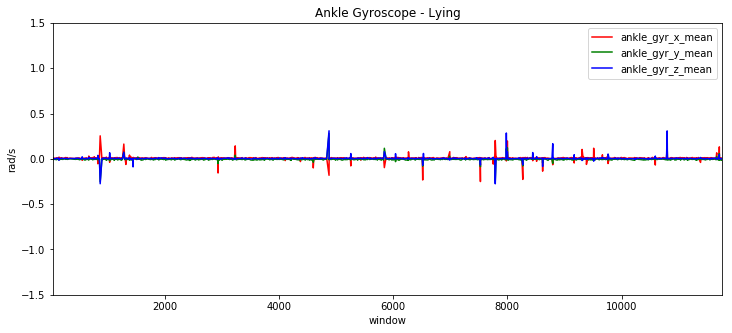

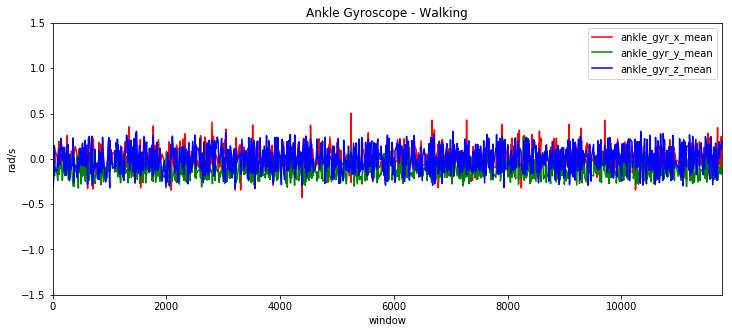

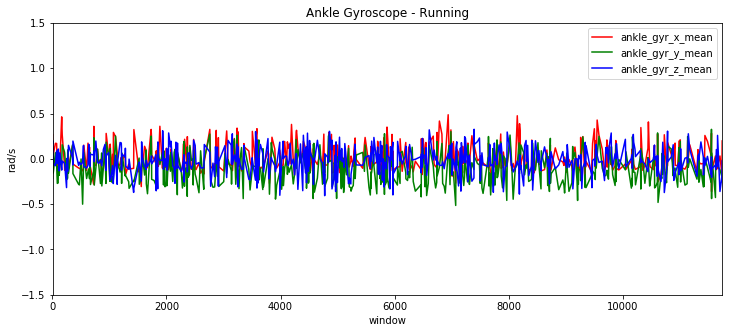

In [21]:
df1=dev_data_df[dev_data_df['activity_id']==1]
df2=dev_data_df[dev_data_df['activity_id']==4]
df3=dev_data_df[dev_data_df['activity_id']==5]

feat = 'Gyroscope'
unit = 'rad/s'
pylimit = (-1.5,1.5)

plot_series(df1, feat, 'Hand', 'Lying', unit, pylimit)
plot_series(df2, feat, 'Hand', 'Walking', unit, pylimit)
plot_series(df3, feat, 'Hand', 'Running', unit, pylimit)

plot_series(df1, feat, 'Chest', 'Lying', unit, pylimit)
plot_series(df2, feat, 'Chest', 'Walking', unit, pylimit)
plot_series(df3, feat, 'Chest', 'Running', unit, pylimit)

plot_series(df1, feat, 'Ankle', 'Lying', unit, pylimit)
plot_series(df2, feat, 'Ankle', 'Walking', unit, pylimit)
plot_series(df3, feat, 'Ankle', 'Running', unit, pylimit)

Gyroscope readings appear harder to differentiate to the naked eye, but they might still be useful for training classifier models.

### 5. Hypothesis Development and Testing

The following class has been created to facilitate the calculations necessary for testing the hypotheses.

In [22]:
class meandiffanalysis:
    """
    This class is used to perform a statistical analysis of the difference of means between two samples. 
    It receives a dictionary with the statistics of each of the samples, namely  mean, median, std, total items and 
    name.
    
    The class has several methods that use these statistics to calculate the difference between the sample means,
    as well as the p-values using either normal or t distributions.
    
    Each method displays its result as HTML to create more visually attractive output.
    """   
    
    def __init__(self, datadict):
        """Assign dicitionary values to local variables"""
        self.sam1 = datadict['sam1']
        self.sam2 = datadict['sam2']
        self.mean1 = datadict['mean1']
        self.median1 = datadict['median1']
        self.std1 = datadict['std1']
        self.count1 = datadict['count1']
        self.mean2 = datadict['mean2']
        self.median2 = datadict['median2']
        self.std2 = datadict['std2']
        self.count2 = datadict['count2']
        self.nullhyp = datadict['nullhyp']
    
    def displaystattable(self):
        """Displays a table with the basic statistics of the two samples being compared"""
        display(HTML("<table><tr><th></th><th>Mean</th><th>Median</th><th>Std Dev</th><th>Count</th></tr>"
                 "<tr><th>{}</th><td>{:,.4f}</td><td>{:,.4f}</td><td>{:,.4f}</td><td>{:,}</td></tr>"
                 "<tr><th>{}</th><td>{:,.4f}</td><td>{:,.4f}</td><td>{:,.4f}</td><td>{:,}</td></tr></table><br>"
                 .format(self.sam1, self.mean1, self.median1, self.std1, self.count1, self.sam2, self.mean2, self.median2, self.std2, self.count2)))
    
    def displayhypotheses(self):
        """Displays the null and alternative hypotheses"""
        display(HTML("<b>Null Hypothesis</b><br>H<sub>0</sub>: μ<sub>1</sub> -  μ<sub>2</sub> = {}".format(self.nullhyp)))
        display(HTML("<b>Alternative Hypothesis</b><br>H<sub>1</sub>: μ<sub>1</sub> -  μ<sub>2</sub> > {}".format(self.nullhyp)))
    
    def displaymeandiff_normal(self):
        """Calculates and displays the difference between the mans of two samples"""
        diff = self.mean1-self.mean2
        comberr = np.sqrt(self.std1**2/self.count1 + self.std2**2/self.count2)
        self.zval = diff/comberr
        display(HTML("<b>Difference between means</b><br>"
                "D ~ N (μ<sub>1</sub> - μ<sub>2</sub> , "
                 "&#x03C3<sub>1</sub><sup>2</sup> / n<sub>1</sub> + "
                 "&#x03C3<sub>2</sub><sup>2</sup> / n<sub>2</sub>)<br>"
                 "P(D ≥ {}) = P( Z ≥ {} / √( "
                 "&#x03C3<sub>1</sub><sup>2</sup> / n<sub>1</sub> + "
                 "&#x03C3<sub>2</sub><sup>2</sup> / n<sub>2</sub>) )<br>"
                 "P(D ≥ {}) = P( Z ≥ {})".format(diff,diff,diff,self.zval)))
    
    def displaypvalue_normal(self):
        """Calculates and displays p-value using the normal distribution"""
        pval = 1 - norm.cdf(self.zval)
        display(HTML("<b>P-value of difference using normal distribution</b><br>{}".format(pval)))
    
    def displaymeandiff_t(self):
        """Calculates and displays the difference between the mans of two samples using t-test"""
        diff = self.mean1-self.mean2
        df = self.count1 + self.count2 - 2
        pools = np.sqrt((((self.count1-1)*self.std1**2) + ((self.count2-1)*self.std2**2))/df)
        se = pools * np.sqrt(1/self.count1 + 1/self.count2)
        self.tval = diff / se         
        display(HTML("<b>Two-sample T-test</b><br>"
                "DF = (n<sub>1</sub> + n<sub>2</sub> - 2 ) <br>"
                "DF = {}<br><br>"
                "s = √ ((n<sub>1</sub>-1)s<sub>1</sub><sup>2</sup> + (n<sub>2</sub>-1)s<sub>2</sub><sup>2</sup> / DF )<br>"
                "s = {}<br><br>"
                "SE = s * √ ( 1 / n<sub>1</sub> + 1 / n<sub>2</sub> )<br>"
                "SE = {}<br><br>"
                "Diff = μ<sub>1</sub> - μ<sub>2</sub><br>"
                "Diff = {}<br><br>"
                "t-statistic = Diff / SE<br>"
                "t-statistic = {}<br>".format(df, pools, se, diff, self.tval)))
        
    def displaypvalue_t(self):
        """Calculates and displays p-value using the t distribution."""
        df = self.count1 + self.count2 - 2
        pval = 1 - the.cdf(self.tval, df)
        display(HTML("<b>P-value of difference using T distribution</b><br>{}".format(pval)))

The first set of hypotheses to be tested concerns the first objective stated for this report. During EDA, the HR data was identified as having the potential to allow classification of activities according to their MET equivalent. To make sure this assessment is correct, a set of two hypotheses regarding the mean of HR data for each MET classification will be tested, specifically, that the mean of their HR data should follow the pattern Light<Moderate<Vigorous.

#### Hypothesis 1a: If HR is correlated with Activity Intensity, then Moderate activities should have a higher mean HR than Light activities.

The first hypothesis to be tested states that the HR mean of Moderate effort activities should be higher than that of light activities. Suitable data for testing is first extracted from the test dataset, and a meandiffanalysis object is created to perform the analysis.

In [23]:
df = test_data_df
df['act_level'] = df['activity_id'].apply(map_met)

#The following two samples of genre will be compared
sam1 = 'moderate'
sam2 = 'light'

#Create dictionary with the necessary statistics to perform the calculation
datadict = {}
datadict['sam1'] = sam1
datadict['sam2'] = sam2
datadict['mean1'] = df[df.act_level==sam1].hr_mean_normal.mean()
datadict['median1'] = df[df.act_level==sam1].hr_mean_normal.median()
datadict['std1'] = df[df.act_level==sam1].hr_mean_normal.std()
datadict['count1'] = df[df.act_level==sam1].hr_mean_normal.count()
datadict['mean2'] = df[df.act_level==sam2].hr_mean_normal.mean()
datadict['median2'] = df[df.act_level==sam2].hr_mean_normal.median()
datadict['std2'] = df[df.act_level==sam2].hr_mean_normal.std()
datadict['count2'] = df[df.act_level==sam2].hr_mean_normal.count()
datadict['nullhyp'] = 0

#Display statistics
h1a=meandiffanalysis(datadict)
h1a.displaystattable()

,Mean,Median,Std Dev,Count
moderate,1.7849,1.7498,0.2510,"2,279"
light,1.2725,1.2414,0.2030,"2,151"


Both samples are of a sufficient size to assume a normal distribution, hence this will be used to calculate the p-value. The null hypothesis will be that the difference between means should equal 0. The alternative hypothesis will be a difference higher than 0. The significance level used will be 0.05.

In [24]:
#Display analysis results
h1a.displayhypotheses()
h1a.displaymeandiff_normal()
h1a.displaypvalue_normal()

With a resulting p-value of 0, the null hypothesis can be rejected. As such it can be concluded with good confidence that Moderate effort activities will have a higher mean HR than light effort activities.

#### Hypothesis 1b: If HR is correlated with Activity Intensity, then Vigorous activities should have a higher mean HR than Moderate activities.

Complementing the previous exercise, the next hypothesis to be tested will be whether the HR mean of Vigorous effort activities is in general higher than that of Moderate activities. Again suitable data for testing is extracted from the test dataset, and a meandiffanalysis object is created.

In [25]:
df = test_data_df
df['act_level'] = df['activity_id'].apply(map_met)

#The following two samples of genre will be compared
sam1 = 'vigorous'
sam2 = 'moderate'

#Create dictionary with the necessary statistics to perform the calculation
datadict = {}
datadict['sam1'] = sam1
datadict['sam2'] = sam2
datadict['mean1'] = df[df.act_level==sam1].hr_mean_normal.mean()
datadict['median1'] = df[df.act_level==sam1].hr_mean_normal.median()
datadict['std1'] = df[df.act_level==sam1].hr_mean_normal.std()
datadict['count1'] = df[df.act_level==sam1].hr_mean_normal.count()
datadict['mean2'] = df[df.act_level==sam2].hr_mean_normal.mean()
datadict['median2'] = df[df.act_level==sam2].hr_mean_normal.median()
datadict['std2'] = df[df.act_level==sam2].hr_mean_normal.std()
datadict['count2'] = df[df.act_level==sam2].hr_mean_normal.count()
datadict['nullhyp'] = 0

#Display statistics
h1b=meandiffanalysis(datadict)
h1b.displaystattable()

,Mean,Median,Std Dev,Count
vigorous,2.2105,2.1893,0.3727,616
moderate,1.7849,1.7498,0.2510,"2,279"


Once again the normal distribution will be employed to calculate p-values. The null hypothesis will be that the difference between means in samples should equal 0. The alternative hypothesis will be a difference higher than 0. The significance level used will be 0.05.

In [26]:
#Display analysis results
h1b.displayhypotheses()
h1b.displaymeandiff_normal()
h1b.displaypvalue_normal()

With a resulting p-value of 0, the null hypothesis can be rejected. It can be concluded with good confidence that Vigorous effort activities will have a higher mean HR than Moderate effort activities.

From the result of these tests it can be reasonably concluded that HR data might be enough to identify activities in the dataset by their MET equivalent. This would be convenient since it would mean that the sensor setup necessary for a tracking  device would be simplified. 

### 6. Model Development and Testing

In the following section, a set of prediction models will be developed and tested in order to answer the questions stated in the objectives of this report. Firs, an overview of the test dataset is given in the following cells

The test dataset is composed of 5046 activity windows, each labelled with one activity id and it's corresponding intensity level. The distributions of the different activities and activity levels present in the dataset are shown below:

Test Dataset by Activity


walking              668
ascending stairs     650
lying                525
Nordic walking       513
sitting              493
standing             483
rope jumping         458
cycling              437
ironing              257
running              242
vacuum cleaning      203
descending stairs    117
Name: Activity Counts, dtype: int64

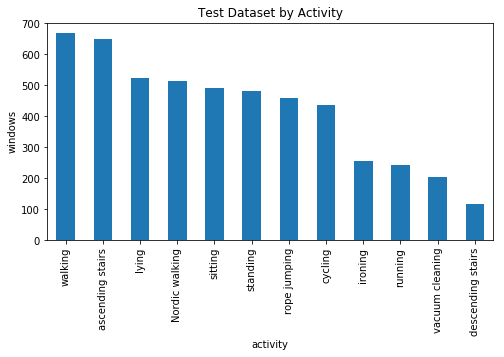

In [7]:
s = test_data_df.groupby('activity_id').count()['act_level']
s = s.rename("Activity Counts")
s.index = [activity_id[x] for x in protocol_acts]
print(('Test Dataset by Activity'))
display(s.sort_values(ascending =False))
ax = s.sort_values(ascending =False).plot(kind='bar', figsize=(8,4))
_ = ax.set_ylabel('windows')
_ = ax.set_xlabel('activity')
_ = ax.set_title('Test Dataset by Activity') 

Test Dataset by Activity Intensity Level


act_level
light       2151
moderate    2279
vigorous     616
Name: Activity Level Counts, dtype: int64

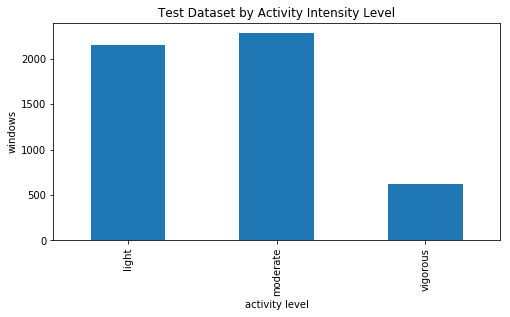

In [8]:
s = test_data_df.groupby('act_level').count()['activity_id']
s = s.rename("Activity Level Counts")
print(('Test Dataset by Activity Intensity Level'))
display(s)
ax = s.plot(kind='bar', figsize=(8,4))
_ = ax.set_ylabel('windows')
_ = ax.set_xlabel('activity level')
_ = ax.set_title('Test Dataset by Activity Intensity Level') 

The following function has been created to display a confusion matrix, and calculate it's associated statistics of accuracy, precision, recall and f-score. It will be used to compare the performance results of different classification models and feature selections.

In [20]:
def confusion_matrix(predict_labels, real_labels, cats, title):
    """
    Function used to display confusion matrix from a set of predicted and real labels. Displays a confusion matrix,
    then uses sklearn library utilities to calculate accuracy, precision, recall and F-score from the data.
    
    Params:
    predict_labels: array of labels predicted by model
    real_labels: array of real labels
    cats: categories for rows and columns of confusion matrix. If false, activity data from protocol activities are used.
    title: title of confusion matrix.
    
    """ 
    pred_results = {}
    base_dict = {}
    
    #If cats parameter is False, the matrix is created with activity data from protocol activities
    if not cats:
        for i in protocol_acts:
            base_dict[i]=0
        for i in protocol_acts:
            pred_results[i] = base_dict.copy()
    else:
        for i in cats:
            base_dict[i]=0
        for i in cats:
            pred_results[i] = base_dict.copy()
    
    #Dictionary is created counting real values for predicted labels
    for pl,tl in list(zip(predict_labels,  real_labels)):
        pred_results[pl][tl]+=1

    pred_results_df = pd.DataFrame(pred_results)
    if not cats:
        pred_results_df.columns=[activity_id[x] for x in protocol_acts]
        pred_results_df.index = [activity_id[x] for x in protocol_acts]
    
    #Accuracy, precision, recall and f-score are calculated using sklearn library
    precision = precision_score(real_labels, predict_labels, average='macro')
    recall = recall_score(real_labels, predict_labels, average='macro')
    accuracy = accuracy_score(real_labels, predict_labels)
    fscore = f1_score(real_labels, predict_labels, average='macro')
    
    #Display results
    print((title))
    display((pred_results_df))
    print(('Accuracy: ' + str(accuracy)))
    print(('Precision: ' + str(precision)))
    print(('Recall: ' + str(recall)))
    print(('F-score: ' + str(fscore)))    

#### Objective 1

The first objective set out at the start of this report was to identify attributes in the data that will allow the recognition of activity intensity, as defined by their MET equivalent. During the EDA portion of the report, the HR data was identified as a possible candidate, since its mean value appeared to closely follow the intensity of an activity. 

This hypothesis was then formally tested in the previous section, with the results seeming to confirm this assessment. Results seemed to indicate that there was enough difference between the HR mean of activities classified by their MET equivalent, that this attribute could be used to differentiate between these classes of activities.

However, there is still matter of being able to make this prediction with an acceptable level of accuracy. Is HR data enough to classify activity intensity with high accuracy? This will be put to the test in the following section. For this purpose, the scikit-learn tree classifier will be used, as this type of classifier has shown the best performance in earlier work in the subject[2,5,7]. For comparison, an SVM classifier from scikit-learn will also be used. 

For a customer facing device or service, a high level of accuracy is required. As such, an accuracy of at least 0.95 will be defined as a requirement to answer this question. A comparable level of precision and recall is desired, though no specific requirement will be stated.

#### Training Classifiers with HR features

First, a decision tree classifier is used, trained using only HR features extracted from the raw data. These features are: HR mean, HR standard deviation, HR normalised mean and HR normalised standard deviation. Using only these features, the classifier reaches an accuracy level of 0.8874. While it's a relatively good performance, it's below the stated requirement. As can be seen from the confusion matrix, there is significant spill over of prediction into neighbouring  categories, eg. light categories being classified as moderate, and although low, there is also mislabelling into the furthest category, eg. from light to vigorous. This means that although HR might be a reasonably good predictor of activity intensity, it's not accurate enough for the purpose of this report.

In [21]:
tclf = tree.DecisionTreeClassifier()

features_used = ['hr_mean','hr_mean_normal','hr_std','hr_std_normal']
label_col = 'act_level'

train_data = np.array(dev_data_df.loc[:, features_used])
train_labels = np.array(dev_data_df.loc[:, label_col])
tclf.fit(train_data, train_labels) 

test_data = np.array(test_data_df.loc[:, features_used])
real_labels = np.array(test_data_df.loc[:, label_col])

predict_labels = tclf.predict(test_data)
confusion_matrix(predict_labels, real_labels, ['light','moderate','vigorous'], "Confusion Matrix for Decision Tree using HR features only")

Confusion Matrix for Decision Tree using HR features only


,light,moderate,vigorous
light,2021,127,3
moderate,138,2002,139
vigorous,6,155,455


Accuracy: 0.887435592549
Precision: 0.857387916941
Recall: 0.852218273505
F-score: 0.854738090002


The same set of features is used to train an SVM classifier. Performance metrics are on a similar level, with a slightly lower accuracy of 0.8739. Similar behaviour as before can be observed in the confusion matrix. This serves to confirm the findings of the previous test, and the need to employ additional features for activity level identification

In [22]:
vclf = svm.SVC()

features_used = ['hr_mean','hr_mean_normal','hr_std','hr_std_normal']
label_col = 'act_level'

train_data = np.array(dev_data_df.loc[:, features_used])
train_labels = np.array(dev_data_df.loc[:, label_col])
vclf.fit(train_data, train_labels)

test_data = np.array(test_data_df.loc[:, features_used])
real_labels = np.array(test_data_df.loc[:, label_col])

predict_labels = vclf.predict(test_data)
confusion_matrix(predict_labels, real_labels, ['light','moderate','vigorous'], "Confusion Matrix for SVM using HR features only")

Confusion Matrix for SVM using HR features only


,light,moderate,vigorous
light,1902,247,2
moderate,141,2049,89
vigorous,5,152,459


Accuracy: 0.873959571938
Precision: 0.866755398656
Recall: 0.842816100592
F-score: 0.853390548921


#### Training Classifiers with HR and Accelerometer features

Since the previous two tests demonstrated that HR data is not enough to accurately classify activities by their intensity levels, the training data will now be supplemented with features extracted from accelerometer readings. The features that will be added are: mean and standard deviation of readings for each axis of each accelerometer location. The same classifiers will be trained using this supplemented training set and performance will be measured and compared to the previous results.

First, the procedure is carried out using the decision tree classifier. Improvements are apparent by looking at the confusion matrix, as mislabelling now only ocurrs into neighbouring categories. The overall amount of mislabelled data is lower as well. The accuracy level is now 0.9859, which meets the stated requirements. Precision, recall and F-score values are very close.  

In [23]:
features_used = ['hr_mean','hr_mean_normal','hr_std','hr_std_normal',
                    'hand_acc_x_mean','hand_acc_x_std','hand_acc_y_mean','hand_acc_y_std','hand_acc_z_mean','hand_acc_z_std',
                    'chest_acc_x_mean','chest_acc_x_std','chest_acc_y_mean','chest_acc_y_std','chest_acc_z_mean','chest_acc_z_std',
                    'ankle_acc_x_mean','ankle_acc_x_std','ankle_acc_y_mean','ankle_acc_y_std','ankle_acc_z_mean','ankle_acc_z_std'
                ]
label_col = 'act_level'

train_data = np.array(dev_data_df.loc[:, features_used])
train_labels = np.array(dev_data_df.loc[:, label_col])
tclf.fit(train_data, train_labels) 

test_data = np.array(test_data_df.loc[:, features_used])
real_labels = np.array(test_data_df.loc[:, label_col])

predict_labels = tclf.predict(test_data)
confusion_matrix(predict_labels, real_labels, ['light','moderate','vigorous'], "Confusion Matrix for Decision Tree using HR  and Accelerometer features")

Confusion Matrix for Decision Tree using HR  and Accelerometer features


,light,moderate,vigorous
light,2131,20,0
moderate,7,2254,18
vigorous,0,26,590


Accuracy: 0.985929449069
Precision: 0.982373549636
Recall: 0.979174827766
F-score: 0.980750514993


Finally, the SVM classifier is also trained using the supplemented training set. It shows even better performance than the decision tree classifier, with accuracy = 0.9994, as well as precision, recall and F-score. This shows that supplementing HR data with accelerometer readings might be a viable solution to be able to classify activity intensity level with an almost perfect accuracy.

In [24]:
features_used = ['hr_mean','hr_mean_normal','hr_std','hr_std_normal',
                    'hand_acc_x_mean','hand_acc_x_std','hand_acc_y_mean','hand_acc_y_std','hand_acc_z_mean','hand_acc_z_std',
                    'chest_acc_x_mean','chest_acc_x_std','chest_acc_y_mean','chest_acc_y_std','chest_acc_z_mean','chest_acc_z_std',
                    'ankle_acc_x_mean','ankle_acc_x_std','ankle_acc_y_mean','ankle_acc_y_std','ankle_acc_z_mean','ankle_acc_z_std'
                ]
label_col = 'act_level'

train_data = np.array(dev_data_df.loc[:, features_used])
train_labels = np.array(dev_data_df.loc[:, label_col])
vclf.fit(train_data, train_labels)

test_data = np.array(test_data_df.loc[:, features_used])
real_labels = np.array(test_data_df.loc[:, label_col])

predict_labels = vclf.predict(test_data)
confusion_matrix(predict_labels, real_labels, ['light','moderate','vigorous'], "Confusion Matrix for SVM using HR and Accelerometer features")

Confusion Matrix for SVM using HR and Accelerometer features


,light,moderate,vigorous
light,2151,0,0
moderate,1,2278,0
vigorous,0,2,614


Accuracy: 0.999405469679
Precision: 0.999552707668
Recall: 0.998771485937
F-score: 0.999161182898


The results of these tests demonstrate that while HR readings are enough to perform reasonably good classification of activity intensity levels, in order to reach an accuracy level that is better suited to a commercial application, it's necessary to supplement this data with additional sensor information, for which accelerometer readings show great performance.

#### Objective 2

The second objective for this report is to compare the performance of different sensing devices present in the dataset, when applied to the identification of physical activities. Specifically, the contribution of features extracted from accelerometer and gyrosocope readings when training a classifier will be measured and compared. 


#### Training Classifiers using  only Accelerometer features
First, a decision tree classifier will be trained using features extracted from accelerometer readings. These features are: mean, standard deviation and correlation of axis pairings of each axis for every sensor location, for a total of 27 features. Using this training set, the decision tree classifier is able to reach an accuracy of 0.9795, with comparable levels of precision and recall. This demonstrates using only accelerometer data allows for very good classification performance.

In [31]:
features_used = ['hand_acc_x_mean','hand_acc_x_std','hand_acc_y_mean','hand_acc_y_std','hand_acc_z_mean','hand_acc_z_std',
                    'chest_acc_x_mean','chest_acc_x_std','chest_acc_y_mean','chest_acc_y_std','chest_acc_z_mean','chest_acc_z_std',
                    'ankle_acc_x_mean','ankle_acc_x_std','ankle_acc_y_mean','ankle_acc_y_std','ankle_acc_z_mean','ankle_acc_z_std',
                    'hand_acc_xy_cor','hand_acc_yz_cor','hand_acc_xz_cor','chest_acc_xy_cor','chest_acc_yz_cor','chest_acc_xz_cor',
                    'ankle_acc_xy_cor','ankle_acc_yz_cor','ankle_acc_xz_cor'
                ]
label_col = 'activity_id'

train_data = np.array(dev_data_df.loc[:, features_used])
train_labels = np.array(dev_data_df.loc[:, label_col])
tclf.fit(train_data, train_labels) 

test_data = np.array(test_data_df.loc[:, features_used])
real_labels = np.array(test_data_df.loc[:, label_col])

predict_labels = tclf.predict(test_data)
confusion_matrix(predict_labels, real_labels, False, "Confusion Matrix for Decision Tree using Accelerometer features")

Confusion Matrix for Decision Tree using Accelerometer features


,lying,sitting,standing,walking,running,cycling,Nordic walking,ironing,vacuum cleaning,rope jumping,ascending stairs,descending stairs
lying,525,0,0,0,0,0,0,0,0,0,0,0
sitting,0,485,2,0,0,0,0,0,0,1,5,0
standing,0,7,471,0,0,2,0,0,0,1,2,0
walking,0,0,0,656,0,0,3,6,3,0,0,0
running,0,0,0,0,242,0,0,0,0,0,0,0
cycling,0,1,0,0,0,428,0,0,0,8,0,0
Nordic walking,0,0,0,0,1,0,512,0,0,0,0,0
ironing,0,0,0,3,0,1,0,248,3,2,0,0
vacuum cleaning,0,0,0,2,0,0,0,2,197,2,0,0
rope jumping,0,1,2,0,0,7,0,1,0,437,10,0


Accuracy: 0.979587792311
Precision: 0.979568611624
Recall: 0.979626123112
F-score: 0.979579910999


#### Training Classifiers using  only Gyroscope features

Next, the decision tree classifier is trained using features extracted from gyroscope readings. The feature set is very similar to the previous one, but applied to the gyroscope data found in the dataset: mean, standard deviation and correlation of axis pairings of each axis for every sensor location, for a total of 27 featues. 

With this training set, the decision tree classifier is only able to reach an accuracy of 0.8973, which while a resonably good level of performance, is considerably lower than that of the accelerometer, and not ideal for the application considered in this report, and 

In [32]:
features_used = ['hand_gyr_x_mean','hand_gyr_x_std','hand_gyr_y_mean','hand_gyr_y_std','hand_gyr_z_mean','hand_gyr_z_std',
                    'chest_gyr_x_mean','chest_gyr_x_std','chest_gyr_y_mean','chest_gyr_y_std','chest_gyr_z_mean','chest_gyr_z_std',
                    'ankle_gyr_x_mean','ankle_gyr_x_std','ankle_gyr_y_mean','ankle_gyr_y_std','ankle_gyr_z_mean','ankle_gyr_z_std',
                    'hand_gyr_xy_cor','hand_gyr_yz_cor','hand_gyr_xz_cor','chest_gyr_xy_cor','chest_gyr_yz_cor','chest_gyr_xz_cor',
                    'ankle_gyr_xy_cor','ankle_gyr_yz_cor','ankle_gyr_xz_cor']
label_col = 'activity_id'

train_data = np.array(dev_data_df.loc[:, features_used])
train_labels = np.array(dev_data_df.loc[:, label_col])
tclf.fit(train_data, train_labels) 

test_data = np.array(test_data_df.loc[:, features_used])
real_labels = np.array(test_data_df.loc[:, label_col])

predict_labels = tclf.predict(test_data)
confusion_matrix(predict_labels, real_labels, False, "Confusion Matrix for Decision Tree using Gyroscope features")

Confusion Matrix for Decision Tree using Gyroscope features


,lying,sitting,standing,walking,running,cycling,Nordic walking,ironing,vacuum cleaning,rope jumping,ascending stairs,descending stairs
lying,433,62,22,0,0,1,0,0,0,3,4,0
sitting,43,395,45,0,0,0,0,0,0,4,6,0
standing,21,36,385,0,0,3,0,0,0,7,31,0
walking,0,0,0,655,0,0,10,3,0,0,0,0
running,0,0,0,0,241,0,0,1,0,0,0,0
cycling,1,1,4,0,0,412,0,3,0,11,5,0
Nordic walking,0,0,0,7,0,0,504,0,2,0,0,0
ironing,0,0,0,3,0,0,0,253,0,0,0,1
vacuum cleaning,0,0,0,0,0,0,3,3,194,1,0,2
rope jumping,1,4,9,0,0,10,1,3,1,392,34,3


Accuracy: 0.897344431233
Precision: 0.910881124535
Recall: 0.913522455503
F-score: 0.911927600365


#### Training Classifiers using both Accelerometer and Gyroscope features

Finally, a test is performed employing a training set composed of both accelerometer and gyroscope features, to measure the performance impact of using both sets of sensors. This means a total of 54 features is used to train the decision tree classifier.

Surprisingly, using this new training set, the classifier only reaches an accuracy of 0.9819, a marginal improvement over the 0.9795 reached when it was trained using only accelerometer data. The addition of the gyroscope data had an effectively negligible effect on the classifier's performance. From this, it can be concluded that, at least with the current selection of features, the addition of a gyroscope sensor to an accelerometer does not produce enough gains to justify its use.

In [27]:
features_used = ['hand_acc_x_mean','hand_acc_x_std','hand_acc_y_mean','hand_acc_y_std','hand_acc_z_mean','hand_acc_z_std',
                    'chest_acc_x_mean','chest_acc_x_std','chest_acc_y_mean','chest_acc_y_std','chest_acc_z_mean','chest_acc_z_std',
                    'ankle_acc_x_mean','ankle_acc_x_std','ankle_acc_y_mean','ankle_acc_y_std','ankle_acc_z_mean','ankle_acc_z_std',
                    'hand_acc_xy_cor','hand_acc_yz_cor','hand_acc_xz_cor','chest_acc_xy_cor','chest_acc_yz_cor','chest_acc_xz_cor',
                    'ankle_acc_xy_cor','ankle_acc_yz_cor','ankle_acc_xz_cor',
                 'hand_gyr_x_mean','hand_gyr_x_std','hand_gyr_y_mean','hand_gyr_y_std','hand_gyr_z_mean','hand_gyr_z_std',
                    'chest_gyr_x_mean','chest_gyr_x_std','chest_gyr_y_mean','chest_gyr_y_std','chest_gyr_z_mean','chest_gyr_z_std',
                    'ankle_gyr_x_mean','ankle_gyr_x_std','ankle_gyr_y_mean','ankle_gyr_y_std','ankle_gyr_z_mean','ankle_gyr_z_std',
                    'hand_gyr_xy_cor','hand_gyr_yz_cor','hand_gyr_xz_cor','chest_gyr_xy_cor','chest_gyr_yz_cor','chest_gyr_xz_cor',
                    'ankle_gyr_xy_cor','ankle_gyr_yz_cor','ankle_gyr_xz_cor'
                ]
label_col = 'activity_id'

train_data = np.array(dev_data_df.loc[:, features_used])
train_labels = np.array(dev_data_df.loc[:, label_col])
tclf.fit(train_data, train_labels) 

test_data = np.array(test_data_df.loc[:, features_used])
real_labels = np.array(test_data_df.loc[:, label_col])

predict_labels = tclf.predict(test_data)
confusion_matrix(predict_labels, real_labels, False, "Confusion Matrix for Decision Tree using Accelerometer and Gyroscope features")

Confusion Matrix for Decision Tree using Accelerometer and Gyroscope features


,lying,sitting,standing,walking,running,cycling,Nordic walking,ironing,vacuum cleaning,rope jumping,ascending stairs,descending stairs
lying,525,0,0,0,0,0,0,0,0,0,0,0
sitting,0,487,2,0,0,1,0,0,0,0,3,0
standing,0,8,468,0,0,0,0,0,0,0,7,0
walking,0,0,0,663,0,0,3,1,0,1,0,0
running,0,0,0,0,242,0,0,0,0,0,0,0
cycling,0,0,0,0,0,430,0,0,0,5,2,0
Nordic walking,0,0,0,6,0,0,505,1,1,0,0,0
ironing,0,0,0,5,0,0,0,250,1,1,0,0
vacuum cleaning,0,0,0,4,0,0,5,1,193,0,0,0
rope jumping,0,1,2,1,0,1,1,0,0,446,6,0


Accuracy: 0.981965913595
Precision: 0.984589895818
Recall: 0.980720978165
F-score: 0.98259623316


From the previous set of tests, it can be concluded that the most efficient sensor setup for a fitness tracking device, might be simply the use of an accelerometer, as it provides a very good level of prediction accuracy, while the addition of gyroscope simply does not provide enough of an improvement to justify the increased complexity of the device, as its effect on performance is negligible.

#### Objective 3

The third objective of this report is to compare the performance of the different sensor locations provided in the PAMAP2 dataset: hand, ankle and chest sensors. Having this information will help the design of better tracking devices, as it will allow designers to select the ideal type of device to create. 

In the following tests, sensor data from each of these locations will be used individually to train a decision tree classifier, and the performance for each will be measured and compared. Since in the last section of this report it was found that accelerometer data provides the best prediction performance for classifiers, only those features will be used in these tests.

#### Training Classifiers using Hand Accelerometer features

For the first test, features extracted from accelerometer readings from a sensor located in the subject's hand are used to train a decision tree classifier. These features are mean, standard deviation and correlation of each pairing of the axes, a total of 9 features. Using this training set, the classifier reaches an accuracy of 0.9215, which is very good performance.

In [28]:
features_used = ['hand_acc_x_mean','hand_acc_x_std','hand_acc_y_mean','hand_acc_y_std','hand_acc_z_mean','hand_acc_z_std',
                    'hand_acc_xy_cor','hand_acc_yz_cor','hand_acc_xz_cor']
label_col = 'activity_id'

train_data = np.array(dev_data_df.loc[:, features_used])
train_labels = np.array(dev_data_df.loc[:, label_col])
tclf.fit(train_data, train_labels) 

test_data = np.array(test_data_df.loc[:, features_used])
real_labels = np.array(test_data_df.loc[:, label_col])

predict_labels = tclf.predict(test_data)
confusion_matrix(predict_labels, real_labels, False, "Confusion Matrix for Decision Tree using Hand Accelerometer features")

Confusion Matrix for Decision Tree using Hand Accelerometer features


,lying,sitting,standing,walking,running,cycling,Nordic walking,ironing,vacuum cleaning,rope jumping,ascending stairs,descending stairs
lying,513,7,2,0,0,0,0,0,0,3,0,0
sitting,7,463,9,0,0,0,0,0,0,0,13,1
standing,3,10,441,4,0,0,0,2,3,11,9,0
walking,0,0,2,639,0,1,0,10,4,12,0,0
running,0,0,0,0,240,0,0,0,0,1,0,1
cycling,0,0,0,0,0,412,0,0,5,9,11,0
Nordic walking,0,0,1,2,0,0,504,0,1,5,0,0
ironing,0,1,6,19,0,0,1,207,10,9,4,0
vacuum cleaning,0,2,1,3,0,2,2,14,151,20,8,0
rope jumping,0,2,13,7,0,6,2,9,12,377,29,1


Accuracy: 0.921521997622
Precision: 0.917773383088
Recall: 0.912403573999
F-score: 0.9149258371


#### Training Classifiers using Chest Accelerometer features

In the next test, the same feature set is used to train the classifier, except the data are extracted from the chest sensor. With this training set, the classifier reaches an accuracy of 0.9288, slightly better than that achieved with the hand sensor data. Interestingly, recall and F-score have a more marked improvement in comparison.

In [33]:
features_used = ['chest_acc_x_mean','chest_acc_x_std','chest_acc_y_mean','chest_acc_y_std','chest_acc_z_mean','chest_acc_z_std',
                    'chest_acc_xy_cor','chest_acc_yz_cor','chest_acc_xz_cor']
label_col = 'activity_id'

train_data = np.array(dev_data_df.loc[:, features_used])
train_labels = np.array(dev_data_df.loc[:, label_col])
tclf.fit(train_data, train_labels) 

test_data = np.array(test_data_df.loc[:, features_used])
real_labels = np.array(test_data_df.loc[:, label_col])

predict_labels = tclf.predict(test_data)
confusion_matrix(predict_labels, real_labels, False, "Confusion Matrix for Decision Tree using Chest Accelerometer features")

Confusion Matrix for Decision Tree using Chest Accelerometer features


,lying,sitting,standing,walking,running,cycling,Nordic walking,ironing,vacuum cleaning,rope jumping,ascending stairs,descending stairs
lying,523,0,1,1,0,0,0,0,0,0,0,0
sitting,0,438,40,0,0,0,0,0,0,4,11,0
standing,0,51,414,0,0,2,0,0,0,0,16,0
walking,1,0,0,628,0,0,18,17,4,0,0,0
running,0,0,0,0,238,0,0,0,1,0,0,3
cycling,0,5,0,0,0,421,0,3,0,7,1,0
Nordic walking,0,0,0,13,0,0,489,8,3,0,0,0
ironing,0,0,0,10,0,2,13,229,3,0,0,0
vacuum cleaning,0,0,0,3,0,0,3,6,191,0,0,0
rope jumping,0,6,1,0,0,8,1,2,0,416,24,0


Accuracy: 0.928854538248
Precision: 0.932111990148
Recall: 0.933174755527
F-score: 0.932573742289


#### Training Classifiers using Ankle Accelerometer features

Finally, the test is repeated using the feature set extracted from the ankle accelerometer data. This time, the classifier reaches an accuracy of 0.9036, lower than the other two locations.

In [30]:
features_used = ['ankle_acc_x_mean','ankle_acc_x_std','ankle_acc_y_mean','ankle_acc_y_std','ankle_acc_z_mean','ankle_acc_z_std',
                    'ankle_acc_xy_cor','ankle_acc_yz_cor','ankle_acc_xz_cor']
label_col = 'activity_id'

train_data = np.array(dev_data_df.loc[:, features_used])
train_labels = np.array(dev_data_df.loc[:, label_col])
tclf.fit(train_data, train_labels) 

test_data = np.array(test_data_df.loc[:, features_used])
real_labels = np.array(test_data_df.loc[:, label_col])

predict_labels = tclf.predict(test_data)
confusion_matrix(predict_labels, real_labels, False, "Confusion Matrix for Decision Tree using Ankle Accelerometer features")

Confusion Matrix for Decision Tree using Ankle Accelerometer features


,lying,sitting,standing,walking,running,cycling,Nordic walking,ironing,vacuum cleaning,rope jumping,ascending stairs,descending stairs
lying,525,0,0,0,0,0,0,0,0,0,0,0
sitting,0,452,9,0,0,2,0,0,0,11,19,0
standing,0,17,382,0,0,0,0,0,0,16,68,0
walking,0,0,0,621,0,0,43,0,4,0,0,0
running,0,0,0,0,240,0,0,0,1,0,0,1
cycling,0,1,1,0,0,421,0,4,0,9,0,1
Nordic walking,0,0,0,20,0,0,491,0,2,0,0,0
ironing,0,0,0,0,0,3,0,245,2,4,0,3
vacuum cleaning,0,0,0,5,2,0,2,6,187,1,0,0
rope jumping,0,5,12,2,0,2,0,0,1,390,46,0


Accuracy: 0.90368608799
Precision: 0.915553124114
Recall: 0.915489867973
F-score: 0.915281715273


From this set of tests, it was found that the location for an accelerometer sensor that provides the best performance for activity prediction is the chest, closely followed by hand, with ankle a more distant third. It can be concluded that a device designed to work while located in the chest of the user would provide the best performance, however a hand device, such as a wristband could still prove practical without much accuracy loss. In this case, the practicality and ease of use of the device may inform the decision further.

### 7. Conclusions

In this report's introduction, three objectives were set out that when answered would provide useful, actionable insights that could be applied in the development of activity tracking hardware and/or software. The PAMAP2 dataset was used to explore different posibilities to answer these questions, and the following conclusions were reached:

- **Objective 1:** With the goal of activity intensity identification, while Heart Rate sensor reading provide enough data for a reasonably good classification, it is not enough to reach the accuracy of 0.95 that was set out as a requirement for the tests. In order to reach this level of accuracy, it's necessary to supplement the HR data with information from additional sensors. In this case, accelerometer readings were used to successfully reach an accuracy of 0.9994 using an SVM classifier. Including both HR and accelerometer sensors in an activity tracking device would be an effective solution if the goal is the correct classification of activities accordingto their intensity. 

- **Objective 2:** Sensor readings from accelerometer and gyroscope devices were used separately to extract features to train a classifier model, and the performance reached with each training set was compared. In this test it was found that accelerometer data provided the best results, with an accuracy of 0.9795, as compared to 0.8973 reached with the gyroscope data. Moreover, when employing both accelerometer and gyroscope originated features to train the classifier, the performance boost was negligible. From this it can be concluded that including an accelerometer sensor might be enough when designing an activity tracking device to get a good level of performance. 

- **Objective 3:** Finally the data from all three sensor locations included in the PAMAP2 dataset was tested, in order to identify the optimal sensor location which provided the best prediction performance. Accelerometer data from each location was used to derive features, and separately trai a classifier. It was found that the chest sensor provided the best accuracy, with 0.9288. However the hand sensor had a just slightly lower accuracy of 0.9215. It should be noted that while solving Objective 2, the accelerometer data for all three sensors was used to train the classifier, and an accuracy of 0.9795 was reached. However wearing all three sensors might not prove to be a practical solution for daily activities. Hence the design of an optimal device must also consider other matters in such as practicality and ease of use.

### 8. References 

[1] B. E. Ainsworth, W. L. Haskell, M. C. Whitt, M. L. Irwin, a. M. Swartz, S. J. Strath, W. L. O'Brien, D. R. Bassett, K. H. Schmitz, P. O. Emplaincourt, D. R. Jacobs, and a. S. Leon. Compendium of physical activities: an update of activity codes and MET intensities. Medicine and science in sports and exercise, 32(9 Suppl), pp. 498-504, Sept. 2000.

[2] A. Reiss and D. Stricker. Creating and Benchmarking a New Dataset for Physical Activity Monitoring. The 5th Workshop on Affect and Behaviour Related Assistance (ABRA), 2012.

[3] PerformedActivitiesSummary.pdf, PAMAP2 Dataset Documentation.

[4] SubjectInformation.pdf, PAMAP2 Dataset Documentation.

[5] A. Reiss and D. Stricker. Towards Global Aerobic Activity Monitoring. In 4th International Conference on Pervasive Technologies Related to Assistive Environments (PETRA), 2011.

[6] N. Ravi, N. Dandekar, P. Mysore, and M. Littman. Activity recognition from accelerometer data. In 17th Conference on Innovative Applications of Artificial Intelligence (IAAI), pp. 1541-1546, 2005.

[7] L. Bao and S. Intille. Activity recognition from user-annotated acceleration data. In Proc. 2nd Int. Conf. Pervasive Computing pp. 1-17, 2004.